# Trust Region Policy Optimization (TRPO) - Policy Gradient

## Preparation

Import packages

In [2]:
%%capture
import matplotlib.pyplot as plt
import pyvirtualdisplay
import numpy as np
import IPython
import torch
import tqdm
import gym
%matplotlib inline

Set up the virtual display

In [3]:
virtual_display = pyvirtualdisplay.Display(visible=0, size=(1400,900))
virtual_display.start()

Set up the gym environment

In [4]:
env = gym.make(
    "LunarLander-v2",
    continuous=True,
    render_mode="rgb_array"
)

Report the observation space and action space

In [5]:
print(env.observation_space)
print(env.action_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Box(-1.0, 1.0, (2,), float32)


Reset the environment

In [6]:
initial_state = env.reset()
print(initial_state)

(array([-0.00648212,  1.413409  , -0.65658194,  0.11060092,  0.00751793,
        0.14872564,  0.        ,  0.        ], dtype=float32), {})


## Random Agent

Verify the environment setup

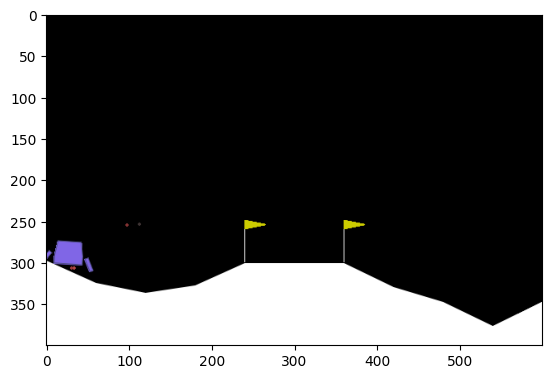

In [8]:
img = plt.imshow(env.render())

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _, _ = env.step(action)
    
    img.set_data(env.render())
    IPython.display.display(plt.gcf())
    IPython.display.clear_output(wait=True)

## Policy Network

In [9]:
class PolicyGradientNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(8,16)
        self.fc2 = torch.nn.Linear(16,16)
        self.fc3 = torch.nn.Linear(16,2)
        
    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return torch.tanh(self.fc3(hid), dim=-1)

## Policy Gradient Agent

In [12]:
class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=0.001)
        
    def learn(self, log_probs, rewards):
        pass
    
    def sample(self, state):
        pass

Initialize the network and the agent

In [13]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Training